# Lecture 6.2 Programming a Deep Neural Network from Scratch with Python



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RandyRDavila/Data_Science_and_Machine_Learning_Spring_2022/blob/main/Lecture_6/Lecture_6_2.ipynb)


In this notebook we implement a deep neural network from scratch (without any libraries to make our model) using Python. The example that we use is the famous [MNIST data set](https://en.wikipedia.org/wiki/MNIST_database) and illustrates how deep neural networks can be used for *computer vision*. 


## MNIST Data Set
The MNIST data set consists of 70,000 images of hand written digits, 60,000 of which are typically used as labeled training examples and the other 10,000 used for testing your learning model on. The following picture represent a sample of some of the images.

<img src="MnistExamples.png" alt="Drawing" style="width: 500px;"/>

We can load this dataset with the ```tensorflow.keras``` package. Load this data by running the following code.

---

In [1]:
#!pip install tensorflow
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt

(train_X, train_y), (test_X, test_y) = keras.datasets.mnist.load_data()

---

The data structures ```train_x``` and ```test_x``` are stored as 3 dimensional tensors. 
 
<img src="order-3-tensor.png" alt="Drawing" style="width: 300px;"/>

This can be varified by finding the shape of these variables. 

---

In [4]:
print(f"{np.shape(train_X) = }")
print(f"{np.shape(test_X) = } \n")

print(f"{np.shape(train_X[0]) = }")
print(f"{np.shape(test_X[0]) = } \n")

print(f"{train_X[0] = }")

np.shape(train_X) = (60000, 28, 28)
np.shape(test_X) = (10000, 28, 28) 

np.shape(train_X[0]) = (28, 28)
np.shape(test_X[0]) = (28, 28) 

train_X[0] = array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,  

---

Each image is comprised of a $28\times 28$ grey scaled grid of pixel values. These values are floating point numbers in the interval $(0,1)$, where darker pixels will have values closer to $1$ and lighter pixels will have values closer to $0$. The following image represents one such example. 

<img src="MNIST-Matrix.png" alt="Drawing" style="width: 600px;"/>

We can view the image of one of these matrices by running the following code.

---

train_y[0] = 5 



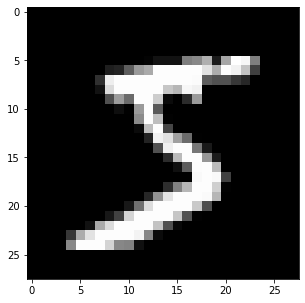

In [5]:
print(f"{train_y[0] = } \n")
plt.figure(figsize=(6, 5))
plt.imshow(train_X[0], cmap="gray")
plt.show()

---

## Image Flattening

Simple **dense neural networks** pass feature vectors into the 0-th (the first) layer of the computational graph represented by the neural network structure as column vectors. This 0-th layer is essentially the same as with single neuron models. In order to feed our images into such a network we must **flatten** the matrix into a column vector.

<img src="flatten.png" alt="Drawing" style="width: 500px;"/>

We can do this for each image matrix we are considering by calling the ```flatten()``` method together with the ```reshape(784, 1)``` method to insure it is a column vector. Note, that $784 = 28 \times 28$. The numerical values in the flattened training and testing data matrices can vary between 0 and 255. These large differences in possible values can lead to problems when training the weights and the biases of the neural network. A quick and dirty fix will be to scale all data to belong in the interval $(0, 1)$, i.e., divide the entries by the largest possible value; in this case 255. 

## One-Hot Encoding 

<img src="onehot.jpeg" alt="Drawing" style="width: 500px;"/>

The following code scales our training and testing data, reshapes our images and stores them in new variable names, and one-hot encodes the labels. 

---

In [6]:
# Scale the data for training. 
train_X = train_X/255
test_X = test_X/255

# Flatten the training images into coloumn vectors. 
flat_train_X = []
for i, x in enumerate(train_X):
    flat_train_X.append(x.flatten().reshape(784, 1))
    
# One hot encode the training labels
onehot_train_y = []
for label in train_y:
    temp_vec = np.zeros((10, 1))
    temp_vec[label][0] = 1.0
    onehot_train_y.append(temp_vec)


# Do the same for the testing data 
flat_test_X = []
for i, x in enumerate(test_X):
    flat_test_X.append(x.flatten().reshape(784, 1))
    
onehot_test_y = []
for label in test_y:
    temp_vec = np.zeros((10, 1))
    temp_vec[label] = 1.0
    onehot_test_y.append(temp_vec)
    

---

## Building the Network Architecture 
For our purposes, we will build a multilayered **fully connected**, or **dense**, neural network with $L$ layers, $784$ input notes, $L-2$ hidden layers of arbitrary size, and $10$ output nodes. 

<img src="multilayerPerceptron.jpg" alt="Drawing" style="width: 450px;"/>

For $\ell = 1, \dots, L$, each layer $\ell$ in our network will have two phases, the preactivation phase $$\mathbf{z}^{\ell} = W^{\ell}\mathbf{a}^{\ell-1} + \mathbf{b}^{\ell},$$ and postactivation phase $$\mathbf{a}^{\ell} = \sigma(\mathbf{z}^{\ell}).$$ The preactivation phase consists of a weighted linear combination of postactivation values in the previous layer. The postactivation values consists of passing the preactivation value through an activation function elementwise. Note $\mathbf{a}^0 = \mathbf{x}^{(i)}$, where $\mathbf{x}^{(i)}$ is the current input data into our network. For our activation function, we will use the sigmoid function:

* Sigmoid Function
$$
\sigma(z) = \frac{1}{1+e^{-z}}.
$$

For our cost function, we will use the Mean Sqaure Error cost:
$$
C(W, b) = \frac{1}{2}\sum_{i=1}^{10}(a^{L}_i - y_i)^2.
$$

Our goal will be to write a custom Python class implementing our desired structure. However, before doing so, we first sequentually write functions to better understand the process of programming the following:

* Initializing the weights and biases of each layer
* The feedforward phase
* Calculation of the cost function
* Calculation of the gradient
* Iterating stochastic gradient descent

First we will define our sigmoid activation function, its derivative, and the mean squared error for a single instance of training data. Do this by running the following code. 

---

In [7]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(10))[0]

---

Next we will write a custom function to initialize the weight matrices and bias column vectors for a dense neural network. Do this by running the following code. 


---

In [8]:
def initialize_weights(layers = [784, 60, 60, 10]):
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network 
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        # The scalling factor is something I found in a research paper :)
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

---

We can test our activation functions and matrix dimensions by running the following code which manually implements the feedforward process on a neural network with the given dimensions.

---

In [9]:
W, B = initialize_weights()

xi = flat_train_X[0]
yi = onehot_train_y[0]
a0 = xi

print(f"{np.shape(a0) = } \n")

z1 = W[1] @ a0 + B[1]
a1 = sigmoid(z1)

print(f"{np.shape(W[1]) = }")
print(f"{np.shape(z1) = }")
print(f"{np.shape(a1) = } \n")

z2 = W[2] @ a1 + B[2]
a2 = sigmoid(z2)

print(f"{np.shape(W[2]) = }")
print(f"{np.shape(z2) = }")
print(f"{np.shape(a2) = } \n")

z3 = W[3] @ a1 + B[3]
a3 = sigmoid(z3)
y_hat = a3
print(f"{np.shape(W[3]) = }")
print(f"{np.shape(z3) = }")
print(f"{np.shape(a3) = } \n")


print(f"Prediction: {np.argmax(y_hat) = }")
print(f"Target Label: {np.argmax(yi) = }")
print(f"{mse(y_hat, yi) = }")

np.shape(a0) = (784, 1) 

np.shape(W[1]) = (60, 784)
np.shape(z1) = (60, 1)
np.shape(a1) = (60, 1) 

np.shape(W[2]) = (60, 60)
np.shape(z2) = (60, 1)
np.shape(a2) = (60, 1) 

np.shape(W[3]) = (10, 60)
np.shape(z3) = (10, 1)
np.shape(a3) = (10, 1) 

Prediction: np.argmax(y_hat) = 8
Target Label: np.argmax(yi) = 5
mse(y_hat, yi) = 1.7993960037677823


In [10]:
def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)
        
        a = sigmoid(z)
        A.append(a)
        
    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def predict(W, B, xi):
    _, A = forward_pass(W, B, xi)
    return np.argmax(A[-1])

y_hat = forward_pass(W, B, flat_train_X[0], predict_vector=True)
print(f"Prediction: {np.argmax(y_hat) = }")
print(f"Target Label: {np.argmax(yi) = }")
print(f"{mse(y_hat, yi) = }")

Prediction: np.argmax(y_hat) = 9
Target Label: np.argmax(yi) = 5
mse(y_hat, yi) = 1.7875889404774847


---




---

In [11]:

def random_experiment(W, B, data_features, data_labels):
    i = np.random.randint(len(data_features))
    print(f"Actual label: {np.argmax(data_labels[i])}")
    print(f"Predicted label: {predict(W, B, data_features[i])}")
    

def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

In [12]:
print(f"{MSE(W, B, flat_train_X, onehot_train_y) = } \n")

random_experiment(W, B, flat_train_X, onehot_train_y)

MSE(W, B, flat_train_X, onehot_train_y) = 1.4460170161975983 

Actual label: 4
Predicted label: 9


---

## Stochastic Gradient Descent 
We are now ready to define a custom Python ```DenseNetwork``` class which initializes the weights and bias for the network, and implements stochastic gradient descent shown below:

1. For each $i = 1, \dots, N$.
2. Feedforward $\mathbf{x}^{(i)}$ into the network. 
3. Compute $\delta^{L} = \nabla_aC\otimes \sigma'(\mathbf{z}^{L})$.
4. For $\ell = L-1, \dots, 1$, compute $\delta^{\ell} = \big ( (\mathbf{w}^{\ell + 1})^{T} \delta^{\ell + 1} \Big )\otimes \sigma'(\mathbf{z}^{\ell})$.
5. For $\ell = L, L-1, \dots, 1$, 

$$
w^{\ell} \leftarrow w^{\ell} - \alpha \delta^{\ell}(\mathbf{a}^{\ell-1})^{T}
$$

$$
b^{\ell} \leftarrow b^{\ell} - \alpha \delta^{\ell}
$$


---

In [13]:

class DenseNetwork(object):
    def __init__(self, layers = [784, 60, 60, 10]):
        self.layers = layers
        self.W, self.B = initialize_weights(layers = self.layers)

    def train(self, X_train, y_train, alpha = 0.046, epochs = 4):
        # Print the initial mean squared error
        print(f"Starting Cost = {MSE(self.W, self.B, X_train, y_train)}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent. 
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error 
                output_error = (A[L] - yi)*d_sigmoid(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function 
                # is non-inclusive. 
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient 
                # descent. 
                for i in range(1, L+1):
                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples     
            print(f"{k + 1}-Epoch Cost = {MSE(self.W, self.B, X_train, y_train)}")
    

    def predict(self, xi):
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])

In [14]:
# Initialize a network with 784 input nodes, two hidden layers with 60 nodes each 
# and a output layer with 10 nodes. 
net = DenseNetwork()

# Train your network with stochastic gradient descent!
net.train(flat_train_X, onehot_train_y)

Starting Cost = 1.5354559929570228
1-Epoch Cost = 0.069550988609842
2-Epoch Cost = 0.050024613325058476
3-Epoch Cost = 0.04053214135554823
4-Epoch Cost = 0.03410103315780225


In [15]:
# Check the mean squared error after training 
MSE(net.W, net.B, flat_test_X, onehot_test_y)

0.03655289020561828

predicted digit is: 7
actual digit is: 2


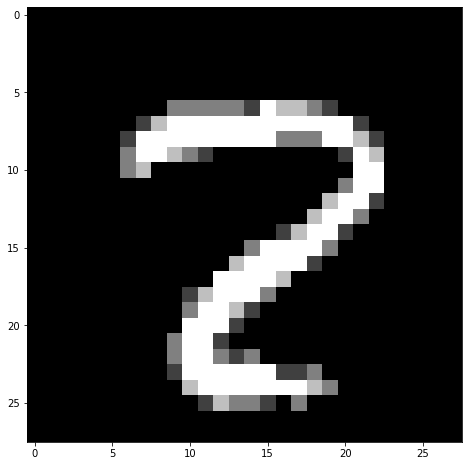

In [16]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 4
actual digit is: 4


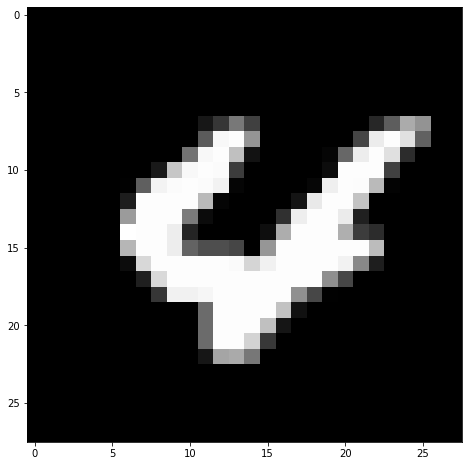

In [17]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 6
actual digit is: 6


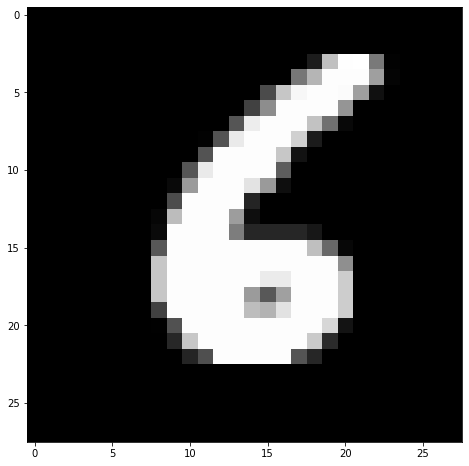

In [18]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 7
actual digit is: 7


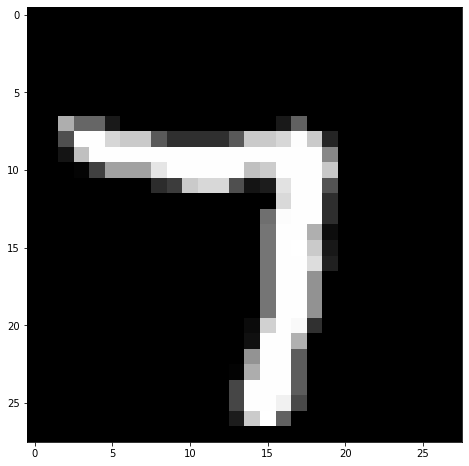

In [19]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 8
actual digit is: 8


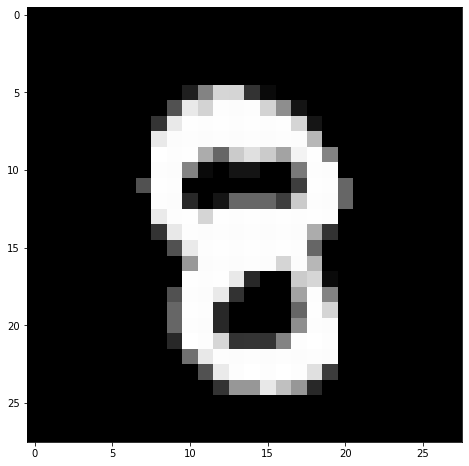

In [20]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 4
actual digit is: 4


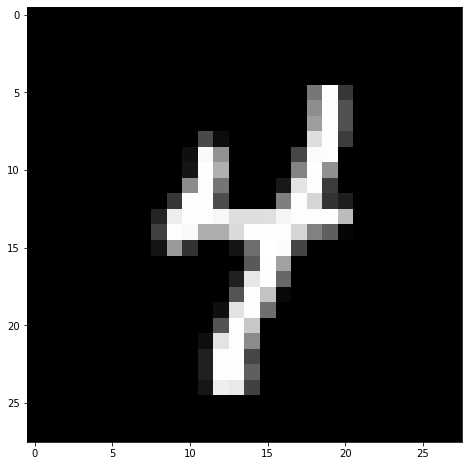

In [21]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 3
actual digit is: 3


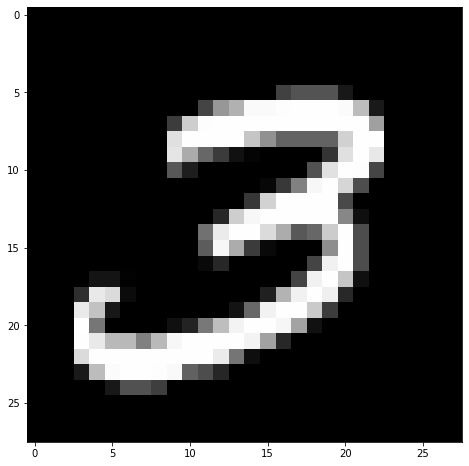

In [22]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

---

## Classification Error
Let us now calculate the classification percentage on the testing data for our trained dense neural network. Recall that this is simply the number of correct labels divided by the total number of data points:

This can be done by running the following code. 


---

In [23]:
# Compute the classification accuracy of our trained model on the test data (I bet we did well!)
sum([int(net.predict(x) == y) for x, y in zip(flat_test_X, test_y)])/len(onehot_test_y)

0.9575